Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
from time import time
from sklearn import datasets
from scipy.special import logsumexp
from sklearn.preprocessing import binarize, LabelBinarizer
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils.validation import check_is_fitted, _check_sample_weight
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline

Base functions of Naive Bayes classification. Functions that are shared by Multinomial and Bernoulli event models.

predict function takes the features and return the result with the highest joint log likelihood.

_log_proba function calculates log probabilities of features with log-sum-exp method. logsumexp helper function from scipy implemented.

_proba function calculates and returns exp of log probability of features.

fit function fits the Naive Bayes classifier according to features and targets.

score function utilizes accuracy score function from sklearn to compute the accuracy, either the fraction or the count of correct predictions.

In [2]:
class NaiveBayesBase():    
    def predict(self, X):
        jll = self._joint_log_likelihood(X)
        return self.classes_[np.argmax(jll, axis=1)]

    def _log_proba(self, X):
        jll = self._joint_log_likelihood(X)
        log_prob_x = logsumexp(jll, axis=1)
        return jll - np.atleast_2d(log_prob_x).T

    def _proba(self, X):
        return np.exp(self._log_proba(X))
    
    def fit(self, X, y, sample_weight=None):
        _, n_f = X.shape

        lbin = LabelBinarizer()
        Y = lbin.fit_transform(y)
        self.classes_ = lbin.classes_
        if Y.shape[1] == 1:
            if len(self.classes_) == 2:
                Y = np.concatenate((1 - Y, Y), axis=1)
            else:
                Y = np.ones_like(Y)

        if sample_weight is not None:
            Y = Y.astype(np.float64, copy=False)
            sample_weight = _check_sample_weight(sample_weight, X)
            sample_weight = np.atleast_2d(sample_weight)
            Y *= sample_weight.T

        n_c = Y.shape[1]
        self.c_count_ = np.zeros(n_c, dtype=np.float64)
        self.f_count_ = np.zeros((n_c, n_f), dtype=np.float64)
        self._count(X, Y)
        self._update_f_log_prob(self.alpha)
        self.c_log_prior_ = np.full(len(self.classes_), -np.log(len(self.classes_)))

        return self

    def score(self, X, y, sample_weight=None):
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
    
    @staticmethod
    def _check_non_negative(X, whom):
        X = X.data if sp.issparse(X) else X
        if (X < 0).any():
            raise ValueError("Negative values by %s" % whom)

Multinomial Naive Bayes

This is a class to create Multinomial NB models to train on data. Laplace smoothing is applied in _update_f_log_proba with the alpha parameter.

In [3]:
class MultinomialNB(NaiveBayesBase):
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        
    def _count(self, X, y):
        #Negative value check - Feature and Class counts
        self._check_non_negative(X, "Multinomial Naive Bayes")
        self.f_count_ += safe_sparse_dot(y.T, X)
        self.c_count_ += y.sum(axis=0)

    def _update_f_log_prob(self, alpha):
        #Laplace smoothing applied with alpha
        smoothed_fc = self.f_count_ + alpha
        smoothed_cc = smoothed_fc.sum(axis=1)
        #Feature log probabilities are calculated after smoothing
        self.f_log_prob_ = np.log(smoothed_fc) - np.log(smoothed_cc.reshape(-1, 1))

    def _joint_log_likelihood(self, X):
        return safe_sparse_dot(X, self.f_log_prob_.T) + self.c_log_prior_

Bernoulli Naive Bayes

This is a class to create Bernoulli NB models to train on data. Laplace smoothing is applied in _update_f_log_proba with the alpha parameter.

In [4]:
class BernoulliNB(NaiveBayesBase):
    def __init__(self, alpha=1.0, binarize=0.0):
        self.alpha = alpha
        self.binarize = binarize

    def _count(self, X, y):
        #Feature and Class counts
        self.f_count_ += safe_sparse_dot(y.T, X)
        self.c_count_ += y.sum(axis=0)

    def _update_f_log_prob(self, alpha):
        #Laplace smoothing applied with alpha
        smoothed_fc = self.f_count_ + alpha
        smoothed_cc = self.c_count_ + alpha * 2
        #Feature log probabilities are calculated after smoothing
        self.f_log_prob_ = np.log(smoothed_fc) - np.log(
            smoothed_cc.reshape(-1, 1)
        )

    def _joint_log_likelihood(self, X):
        #Control the input and the features
        n_f = self.f_log_prob_.shape[1]
        n_f_X = X.shape[1]
        if n_f_X != n_f:
            raise ValueError("Expected input with %d features, got %d instead" % (n_f, n_f_X))
        #Calculate joint log likelihood
        neg_prob = np.log(1 - np.exp(self.f_log_prob_))
        jll = safe_sparse_dot(X, (self.f_log_prob_ - neg_prob).T)
        jll += self.c_log_prior_ + neg_prob.sum(axis=1)
        return jll

k-Fold cross validation

k-fold & crossval functions:
First the number of folds "k" is employed to create the folds. Classically one would divide the dataset to k pieces, put the test set aside, merge the rest to design the training set; however this code works a bit different. Instead of dividing the dataset, the test set is created by taking data out of the dataset by using its index (designed to present different fold with each loop). Rest of the data can be employed as a training data and this solves the problem of division with "k" resulting with a float number instead of an integer.
CountVectorizer function by sklearn is utilized to extract features from the test dataset. It's designed bypassable by calling the crossval function with the "v" parameter valued "False".

In [5]:
def kFold(X, y, k):
    folds = []
    n = int(len(y)/k)
    for i in range(k):
        #take i*n - i*n + n elements out from data, store as test, rest is training
        X_test = X.loc[i*n : i*n+n]
        y_test = y.loc[i*n : i*n+n]
        X_train = X.drop(X.index[i*n : i*n + n])
        y_train = y.drop(y.index[i*n : i*n + n])
        folds.append([X_train, y_train, X_test, y_test])
    return folds

def crossval(clf, folds, k, v=True):
    scores = []
    for i in range(k):
        X_train = folds[i][0]
        y_train = folds[i][1]
        X_test = folds[i][2]
        y_test = folds[i][3]
        if v == True:
            vect = CountVectorizer(lowercase=False)
            X_train_dtm = vect.fit_transform(X_train)
            X_test_dtm = vect.transform(X_test)
            clf.fit(X_train_dtm, y_train)
            labels = clf.predict(X_test_dtm)
        else:
            clf.fit(X_train, y_train)
            labels = clf.predict(X_test)
        score = accuracy_score(labels, y_test)
        scores.append(score)
    return scores

def meanscore(scores):
    mean = sum(scores)/len(scores)
    return mean

def printscores(scores):
    for score in scores:
        print("Accuracy: %f" % score)
    mean = meanscore(scores)
    print("Mean Accuracy of k-fold cross validation: %f" % mean)
    
def compare_plot(score, train_time, test_time):
    indices = np.arange(2)
    clf_names = ["Multinomial Naive Bayes", "Bernoulli Naive Bayes"]
    plt.figure(figsize=(12, 4))
    plt.title("Comparison of Multinomial and Bernoulli Naive Bayes")
    plt.barh(indices, score, 0.2, label="score", color="navy")
    plt.barh(indices + 0.3, train_time, 0.2, label="training time", color="c")
    plt.barh(indices + 0.6, test_time, 0.2, label="test time", color="darkorange")
    plt.yticks(())
    plt.legend(loc="best")
    for i, c in zip(indices, clf_names):
        plt.text(-0.3, i, c)
    plt.show()

Iris Dataset

Iris dataset is an image dataset provided by sklearn.

only Multinomial NB is trained.

In [6]:
iris = datasets.load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
mnb = MultinomialNB(alpha=1.0).fit(X_train, y_train)
labelsm = mnb.predict(X_test)
print("Training score of Multinomial NB on iris dataset: %f" % mnb.score(X_train, y_train))
print("Test score of Multinomial NB on iris dataset: %f" % mnb.score(X_test, y_test))

Training score of Multinomial NB on iris dataset: 0.946429
Test score of Multinomial NB on iris dataset: 0.973684


Here we designed a new data by creating an array just like the dataset's features. Now the model trained previously can be employed to obtain the prediction results. This data is predicted as a 'virginica' by the Multinomial NB model.

In [7]:
new_data = np.array([[2,2.6,5.2,0.7]])
prediction = mnb.predict(new_data)
print("Prediction: {}".format(prediction))
print("Predicted target name: {}".format(iris['target_names'][prediction]))
print("Test set predictions:\n {}".format(labelsm))
print("Test set score: {:.4f}".format(mnb.score(X_test, y_test)))

Prediction: [2]
Predicted target name: ['virginica']
Test set predictions:
 [1 0 2 1 0 0 1 2 0 1 1 1 0 0 2 1 2 2 0 0 0 2 2 0 2 0 2 0 1 2 1 1 2 1 2 0 1
 0]
Test set score: 0.9737


A scatter plot can show how the data is scattered comparing 2 different feature of the data. By using this method, decision boundaries designed by the models can be visualised. 

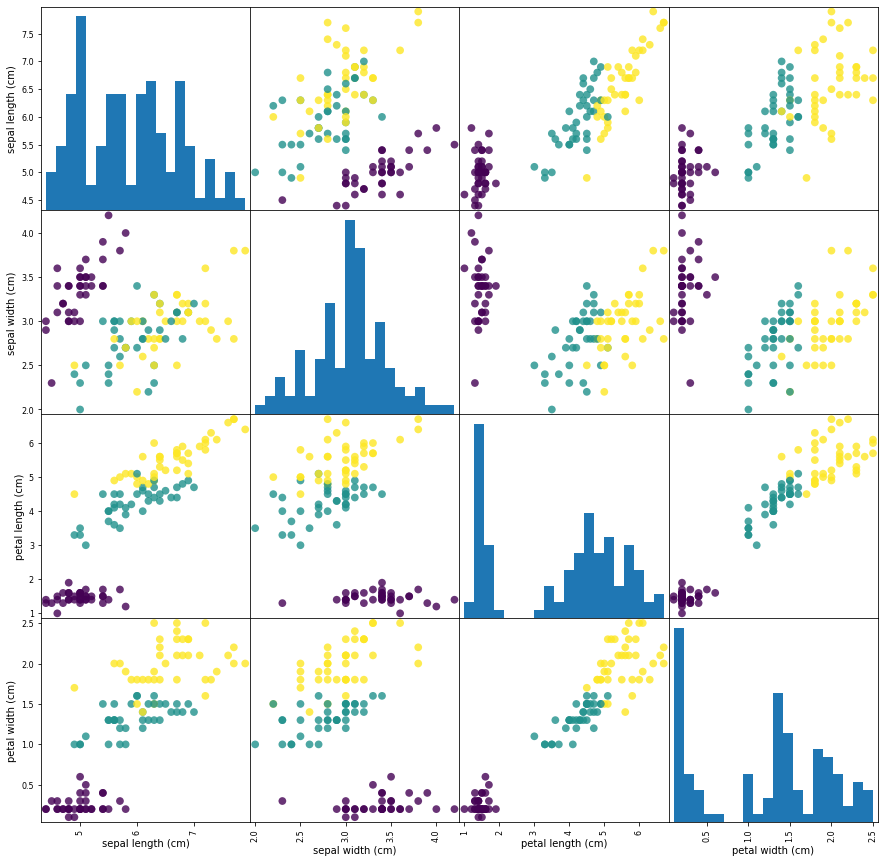

In [8]:
iris_dataframe = pd.DataFrame(X_train, columns=iris.feature_names)
grr = pd.plotting.scatter_matrix(iris_dataframe, c=y_train, figsize=(15, 15), marker='o',hist_kwds={'bins': 20}, s=60, alpha=.8)

This model is trained with a different method, instead of using all 4 features in the iris dataset, only 'petal length (cm)' and 'petal width (cm)' is used. This is designed to show how decision boundaries would look if it is applicable on a 2 dimensional scatter plot.

0.8157894736842105


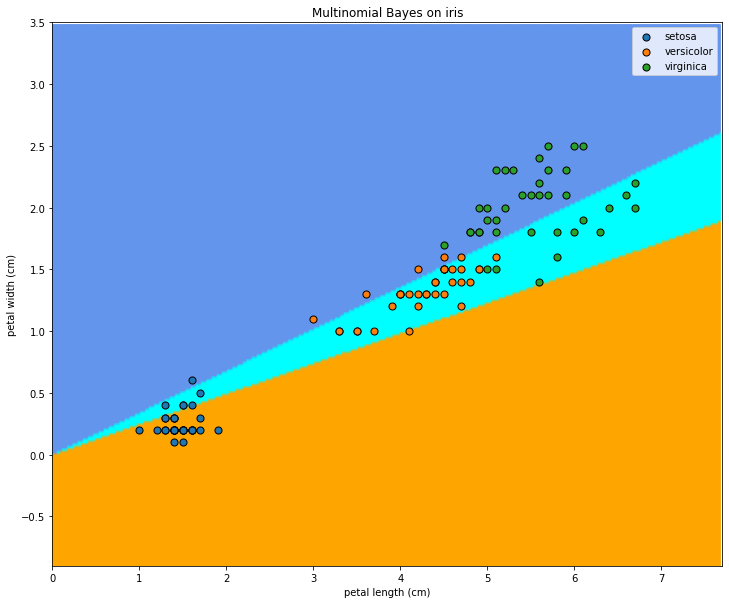

In [9]:
mnb2 = MultinomialNB(alpha=1)
mnb2.fit(X_train[:,2:], y_train)
labelsm2 = mnb2.predict(X_test[:,2:])
scorem2 = accuracy_score(labelsm2, y_test)
print(scorem2)
from matplotlib.colors import ListedColormap

x_min,x_max = X_train[:,2].min() - 1, X_train[:,2].max()+ 1
y_min,y_max = X_train[:,3].min() - 1, X_train[:,3].max()+ 1
h=0.02
xx,yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
Z = mnb2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_b = ListedColormap(['darkorange', 'c', 'darkblue'])
cmap_l = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
fig = plt.figure(figsize = (12,10))
ax1 = fig.add_subplot(111)
ax1.pcolormesh(xx, yy, Z, cmap=cmap_l, shading='gouraud')
for target in iris.target_names:
    index=np.where(iris.target_names==target)[0][0]
    ax1.scatter(X_train[:,2][y_train==index],X_train[:,3][y_train==index],
                cmap=cmap_b,edgecolor='k', s=50, label=target)
ax1.set_xlim(x_min,x_max)
ax1.set_ylim(y_min,y_max)
ax1.legend()
ax1.set_xlabel("petal length (cm)")
ax1.set_ylabel("petal width (cm)")
ax1.set_title("Multinomial Bayes on iris")
plt.show()

The 20 Newsgroups data set

This dataset is provided by sklearn library. Data is set of 18000 newsgroup document split into 20 different newsgroups.
http://qwone.com/~jason/20Newsgroups/
Bernoulli and Multinomial are trained and tested on this dataset.

In [10]:
data20 = fetch_20newsgroups()
categories = data20.target_names
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

modelm = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=1.0))
modelb = make_pipeline(TfidfVectorizer(), BernoulliNB(alpha=1.0, binarize=1.0))
modelm.fit(train.data, train.target)
modelb.fit(train.data, train.target)
labelsm = modelm.predict(test.data)
labelsb = modelb.predict(test.data)

Here is a heatmap showing the Multinomial NB prediction and true label comparison.

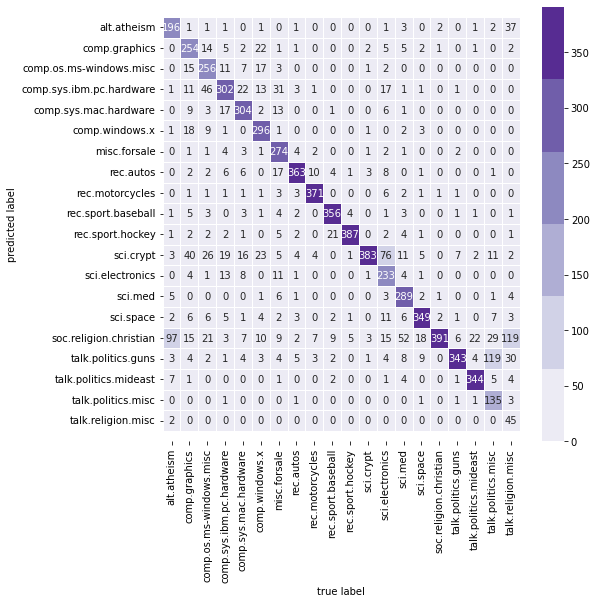

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labelsm)
colormap = sns.color_palette("Purples")
ax = sns.heatmap(mat.T, annot=True, fmt='d', cbar=True, linewidths=1, cmap=colormap, 
            xticklabels=train.target_names, yticklabels=train.target_names)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

Training times, test times and test accuracy for Multinomial NB and BernoulliNB on 20 Newsgroups Dataset

In [12]:
print("Multinomial NB: ")
t0 = time()
modelm.fit(train.data, train.target)
t_train_m = time() - t0
print("Training Time: %0.3fs" % t_train_m)

t0 = time()
predm = modelm.predict(test.data)
t_test_m = time() - t0
print("Test Time:  %0.3fs" % t_test_m)

scorem = accuracy_score(predm, test.target)
print("Accuracy:   %0.3f" % scorem)
print("-------")
print("Bernoulli NB: ")
t0 = time()
modelb.fit(train.data, train.target)
t_train_b = time() - t0
print("Train Time: %0.3fs" % t_train_b)

t0 = time()
predb = modelb.predict(test.data)
t_test_b = time() - t0
print("Test Time:  %0.3fs" % t_test_b)

scoreb = accuracy_score(predb, test.target)
print("Accuracy:   %0.3f" % scoreb)

Multinomial NB: 
Training Time: 1.929s
Test Time:  1.055s
Accuracy:   0.779
-------
Bernoulli NB: 
Train Time: 1.939s
Test Time:  1.102s
Accuracy:   0.394


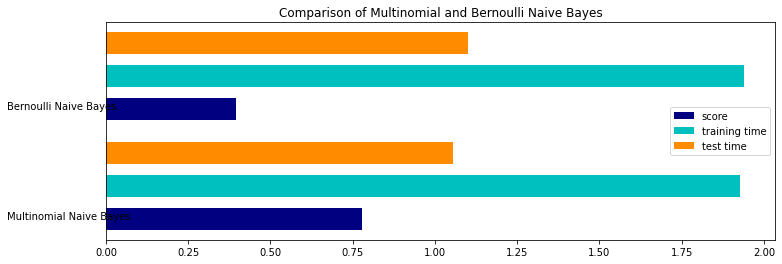

In [13]:
train_time = [t_train_m, t_train_b]
test_time = [t_test_m, t_test_b]
score = [scorem, scoreb]
compare_plot(score, train_time, test_time)

SMS Spam Collection v. 1

"The SMS Spam Collection v.1 is a public set of SMS labeled messages that have been collected for mobile phone spam research. It has one collection composed by 5,574 English, real and non-enconded messages, tagged according being legitimate (ham) or spam."
Almeida, T.A., Gómez Hidalgo, J.M. https://www.dt.fee.unicamp.br/%7Etiago/smsspamcollection/ 2011

text dataset. Multinomial and Bernoulli both trained and tested.

In [14]:
path = 'data/sms.tsv'
features = ['label', 'message']
sms = pd.read_table(path, header=None, names=features)
print(sms.shape)
print(sms.head())
print(sms.label.value_counts())
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})
X = sms.message
y = sms.label_num
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

(5572, 2)
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
ham     4825
spam     747
Name: label, dtype: int64


Training times, test times and test accuracy for Multinomial NB and BernoulliNB on SMS Spam Collection v.1 Dataset

In [15]:
modelm = MultinomialNB(alpha=1)
modelb = BernoulliNB(alpha=1, binarize=1)
print("Multinomial NB: ")
t0 = time()
modelm.fit(X_train_dtm, y_train)
t_train_m = time() - t0
print("Training Time: %0.3fs" % t_train_m)

t0 = time()
predm = modelm.predict(X_test_dtm)
t_test_m = time() - t0
print("Test Time:  %0.3fs" % t_test_m)

scorem = accuracy_score(predm, y_test)
print("Accuracy:   %0.3f" % scorem)
print("-------")
print("Bernoulli NB: ")
t0 = time()
modelb.fit(X_train_dtm, y_train)
t_train_b = time() - t0
print("Train Time: %0.3fs" % t_train_b)

t0 = time()
predb = modelb.predict(X_test_dtm)
t_test_b = time() - t0
print("Test Time:  %0.3fs" % t_test_b)

scoreb = accuracy_score(predb, y_test)
print("Accuracy:   %0.3f" % scoreb)

Multinomial NB: 
Training Time: 0.002s
Test Time:  0.000s
Accuracy:   0.982
-------
Bernoulli NB: 
Train Time: 0.002s
Test Time:  0.001s
Accuracy:   0.985


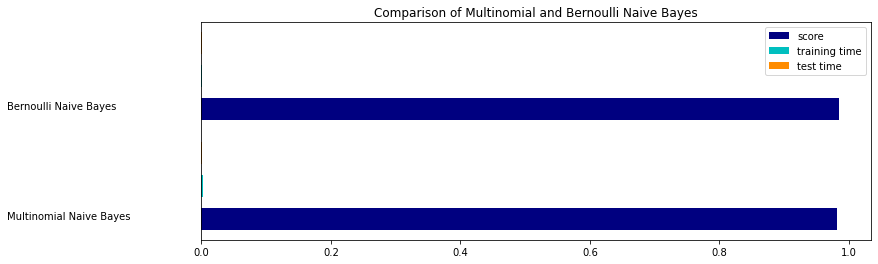

In [16]:
train_time = [t_train_m, t_train_b]
test_time = [t_test_m, t_test_b]
score = [scorem, scoreb]
compare_plot(score, train_time, test_time)

News Category Dataset

"This dataset contains around 200k news headlines from the year 2012 to 2018 obtained from HuffPost. The model trained on this dataset could be used to identify tags for untracked news articles or to identify the type of language used in different news articles." Misra, R. https://www.kaggle.com/rmisra/news-category-dataset/ 2018

Here is a bar plot of category distribution in the dataset.

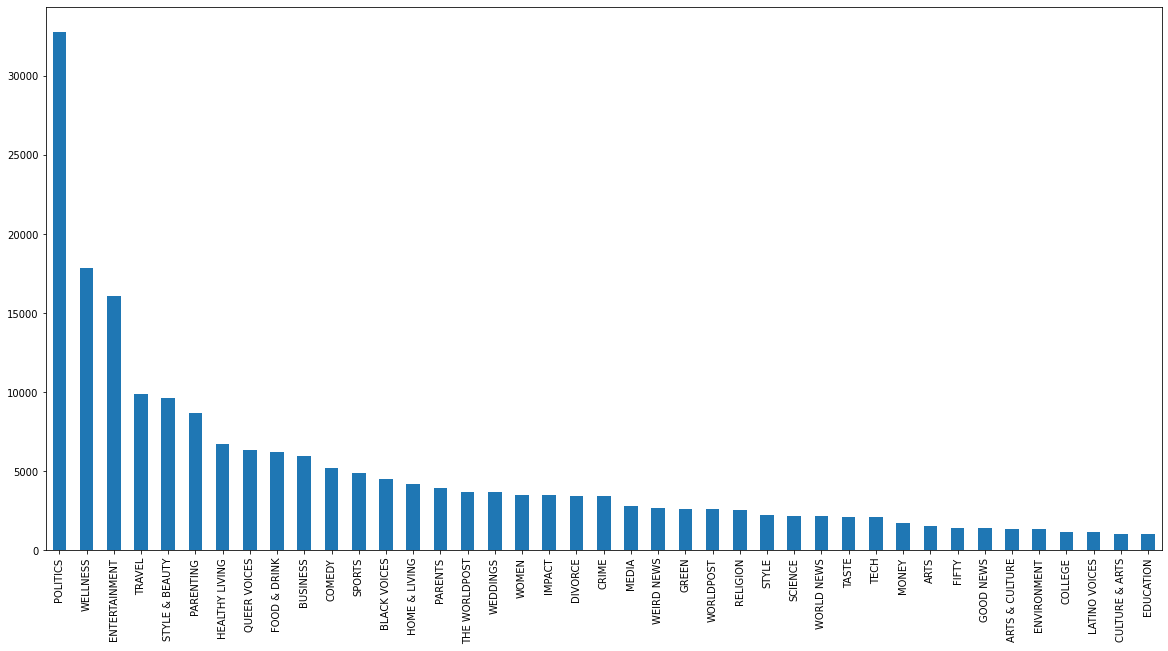

In [17]:
data20v2 = pd.read_json('./data/News_Category_Dataset_v2.json', lines=True)
data20v2 = data20v2[["category", "headline"]]
data20v2.category.value_counts().plot.bar(figsize = (20,10))
plt.show()

Each unique category name is numbered and then used as a target. Each text that represent features vectorized by CountVectorizer function by sklearn. Then the data is split to train and test data by employing the train_test_split function by sklearn. 

In [18]:
mapper = {}
for i,cat in enumerate(data20v2["category"].unique()):
        mapper[cat] = i

data20v2["category_target"] = data20v2["category"].map(mapper)
vect = CountVectorizer(stop_words = 'english')
X_train_matrix = vect.fit_transform(data20v2["headline"]) 
y = data20v2["category_target"]
X_train, X_test, y_train, y_test = train_test_split(X_train_matrix, y, test_size=0.3)

Training times, test times and test accuracy for Multinomial NB and BernoulliNB on News Category Dataset

In [19]:
modelm = MultinomialNB(alpha=1)
modelb = BernoulliNB(alpha=1, binarize=1)
print("Multinomial NB: ")
t0 = time()
modelm.fit(X_train, y_train)
t_train_m = time() - t0
print("Training Time: %0.3fs" % t_train_m)

t0 = time()
predm = modelm.predict(X_test)
t_test_m = time() - t0
print("Test Time:  %0.3fs" % t_test_m)

scorem = accuracy_score(predm, y_test)
print("Accuracy:   %0.3f" % scorem)
print("-------")
print("Bernoulli NB: ")
t0 = time()
modelb.fit(X_train, y_train)
t_train_b = time() - t0
print("Train Time: %0.3fs" % t_train_b)

t0 = time()
predb = modelb.predict(X_test)
t_test_b = time() - t0
print("Test Time:  %0.3fs" % t_test_b)

scoreb = accuracy_score(predb, y_test)
print("Accuracy:   %0.3f" % scoreb)

Multinomial NB: 
Training Time: 0.130s
Test Time:  0.023s
Accuracy:   0.545
-------
Bernoulli NB: 
Train Time: 0.101s
Test Time:  0.060s
Accuracy:   0.412


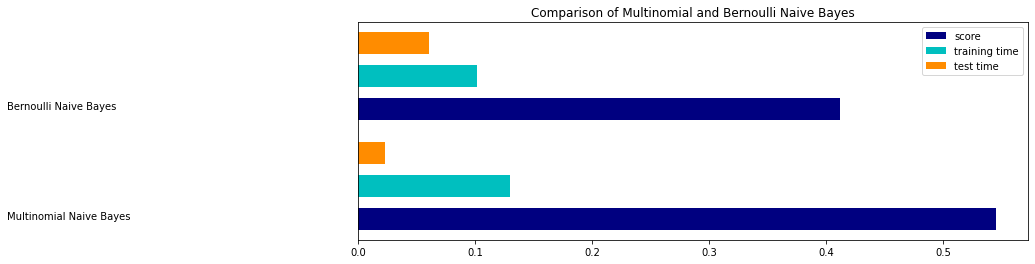

In [20]:
train_time, test_time, score = [t_train_m, t_train_b], [t_test_m, t_test_b], [scorem, scoreb]
compare_plot(score, train_time, test_time)

k-fold cross validation applied with both Multinomial and Bernoulli Naive Bayes models on SMS Spam Collection v.1 Dataset and News Category Dataset. Accuracies for each fold and mean accuracies of k-fold cross validation is shown with the outputs.

In [21]:
X = sms.message
y = sms.label_num
aa = kFold(X, y, 5)
print("5-fold cross validation on Multinomial NB on sms dataset")
printscores(crossval(MultinomialNB(alpha=1),aa, 5))
print("------------")
printscores(crossval(BernoulliNB(alpha=1),aa, 5))
print("5-fold cross validation on Bernoulli NB on sms dataset")

5-fold cross validation on Multinomial NB on sms dataset
Accuracy: 0.980269
Accuracy: 0.981166
Accuracy: 0.975785
Accuracy: 0.976682
Accuracy: 0.977578
Mean Accuracy of k-fold cross validation: 0.978296
------------
Accuracy: 0.979372
Accuracy: 0.980269
Accuracy: 0.974888
Accuracy: 0.975785
Accuracy: 0.979372
Mean Accuracy of k-fold cross validation: 0.977937
5-fold cross validation on Bernoulli NB on sms dataset


In [22]:
X = data20v2.headline
y = data20v2.category_target
bb = kFold(X, y, 5)
print("5-fold cross validation on Multinomial NB on 20 news group v2 dataset")
printscores(crossval(MultinomialNB(alpha=1), bb, 5))
print("------------")
print("5-fold cross validation on Bernoulli NB on 20 news group v2 dataset")
printscores(crossval(BernoulliNB(alpha=1), bb, 5))

5-fold cross validation on Multinomial NB on 20 news group v2 dataset
Accuracy: 0.500909
Accuracy: 0.471310
Accuracy: 0.296234
Accuracy: 0.453959
Accuracy: 0.523263
Mean Accuracy of k-fold cross validation: 0.449135
------------
5-fold cross validation on Bernoulli NB on 20 news group v2 dataset
Accuracy: 0.449628
Accuracy: 0.397476
Accuracy: 0.222499
Accuracy: 0.358816
Accuracy: 0.388315
Mean Accuracy of k-fold cross validation: 0.363347
